## MNIST Image Classification with a Simple Mamba Model

### Build the dataset and dataloader

In [10]:
# %pip install mamba-ssm[causal-conv1d] --upgrade

In [11]:
import os
# no nvlink
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# use a specific GPU
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [12]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
if not os.path.exists("../../assets/MNIST"):
    torchvision.datasets.MNIST(root='../../assets', train=True, download=True, transform=transform)
    torchvision.datasets.MNIST(root='../../assets', train=False, download=True, transform=transform)
else:
    train_dataset = torchvision.datasets.MNIST(root='../../assets', train=True, download=False, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='../../assets', train=False, download=False, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

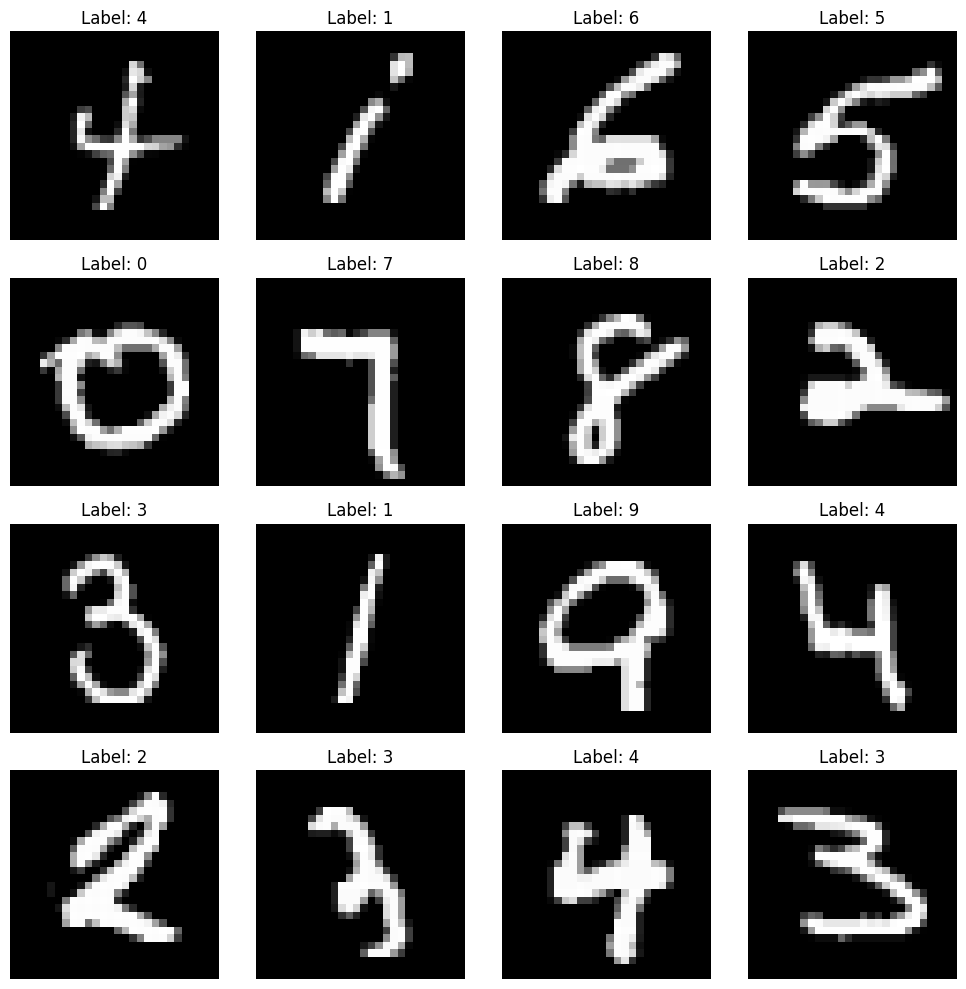

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build a Simple Mamba Model

In [14]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba
from einops import rearrange

# Build a Mamba model for the MNIST dataset
class MambaSimple(nn.Module):
    def __init__(self, dim=49, num_classes=10):
        super(MambaSimple, self).__init__()
        self.blocks = nn.ModuleList([
            Mamba(
                d_model=dim, # Model dimension d_model
                expand=12,
            )
            for _ in range(2)
        ])
        self.fc = nn.Linear(dim*16, num_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, sequence_length, input_size)
        x = x.squeeze(1)
        x = rearrange(x, 'b (p1 h) (p2 w) -> b (p1 p2) (h w)', p1=4, p2=4)
        for block in self.blocks:
            x = block(x)
        
        x = x.flatten(1)
        x = self.fc(x)
        #x = self.fc(x[:, -1, :])
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(64, 1, 28, 28).to(device)
model = MambaSimple()
model.to(device)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

MambaSimple(
  (blocks): ModuleList(
    (0-1): 2 x Mamba(
      (in_proj): Linear(in_features=49, out_features=1176, bias=False)
      (conv1d): Conv1d(588, 588, kernel_size=(4,), stride=(1,), padding=(3,), groups=588)
      (act): SiLU()
      (x_proj): Linear(in_features=588, out_features=36, bias=False)
      (dt_proj): Linear(in_features=4, out_features=588, bias=True)
      (out_proj): Linear(in_features=588, out_features=49, bias=False)
    )
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
torch.Size([64, 10])
Number of parameters: 254,810


### Define the loss function and optimizer

In [15]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [16]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:11<01:39, 11.01s/it]

Epoch: 1, Loss: 0.2107


 20%|██        | 2/10 [00:21<01:27, 10.90s/it]

Epoch: 2, Loss: 0.0730


 30%|███       | 3/10 [00:32<01:16, 10.89s/it]

Epoch: 3, Loss: 0.0568


 40%|████      | 4/10 [00:43<01:05, 10.93s/it]

Epoch: 4, Loss: 0.0439


 50%|█████     | 5/10 [00:54<00:54, 10.94s/it]

Epoch: 5, Loss: 0.0356


 60%|██████    | 6/10 [01:05<00:43, 10.93s/it]

Epoch: 6, Loss: 0.0334


 70%|███████   | 7/10 [01:16<00:33, 11.00s/it]

Epoch: 7, Loss: 0.0249


 80%|████████  | 8/10 [01:27<00:21, 10.98s/it]

Epoch: 8, Loss: 0.0212


 90%|█████████ | 9/10 [01:38<00:10, 10.97s/it]

Epoch: 9, Loss: 0.0192


100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

Epoch: 10, Loss: 0.0172


### Evaluate the model

In [17]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9817


### Predict on sample images

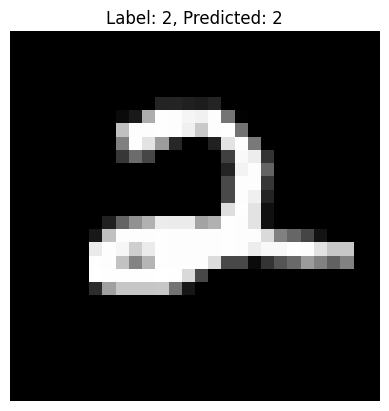

: 

In [18]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
